# ML Forecasting 

**Important Parameters**

**Relevant Information**


In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

pd.options.display.float_format = "{:,.2f}".format

from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error

## Data

In [2]:
def read_dataset():

    url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
    df = pd.read_csv(url)
    df["date"] = pd.to_datetime(df["Month"], format = "%Y-%m")
    df.drop(columns=["Month"], inplace = True)
    df.sort_values(by = ["date"], ascending=True, inplace = True)
    df.reset_index(drop = True, inplace = True)
    df["Passengers"] = df["Passengers"].astype(float)

    return df 

df = read_dataset()
df

,Passengers,date
0,112.00,1949-01-01
1,118.00,1949-02-01
2,132.00,1949-03-01
3,129.00,1949-04-01
4,121.00,1949-05-01
...,...,...
139,606.00,1960-08-01
140,508.00,1960-09-01
141,461.00,1960-10-01
142,390.00,1960-11-01


In [3]:
ts_variable = "Passengers"
date_variable = "date"

In [4]:
# Lest Create the Train and Test Data 
train_size = int(len(df[date_variable])*0.9)
train = df[:train_size].copy()
test = df[train_size:].copy()
train

,Passengers,date
0,112.00,1949-01-01
1,118.00,1949-02-01
2,132.00,1949-03-01
3,129.00,1949-04-01
4,121.00,1949-05-01
...,...,...
124,420.00,1959-05-01
125,472.00,1959-06-01
126,548.00,1959-07-01
127,559.00,1959-08-01


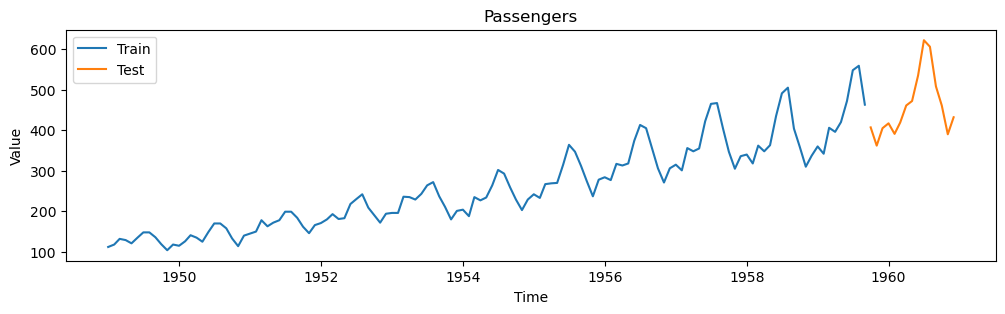

In [5]:
plt.figure(figsize=(12,3))
plt.plot(train[date_variable], train[ts_variable], label = f'Train')
plt.plot(test[date_variable], test[ts_variable], label = f'Test')
plt.title(f"{ts_variable}")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show() 

## Dataset Creation

### 1 Step in Future

In [6]:
n_past_steps = 20
train_data = pd.DataFrame()

for i in range(len(train) + 1 - n_past_steps):
    
    cut = train.iloc[i:i+n_past_steps, :].copy()
    row = pd.Series(cut[ts_variable].values)
    train_data = pd.concat([train_data, row], axis = 1)

train_data = train_data.T
train_data.columns = [f'lag_{i}' for i in reversed(range(1, n_past_steps))] + ["target"]
train_data
    

,lag_19,lag_18,lag_17,lag_16,lag_15,lag_14,lag_13,lag_12,lag_11,lag_10,lag_9,lag_8,lag_7,lag_6,lag_5,lag_4,lag_3,lag_2,lag_1,target
0,112.00,118.00,132.00,129.00,121.00,135.00,148.00,148.00,136.00,119.00,104.00,118.00,115.00,126.00,141.00,135.00,125.00,149.00,170.00,170.00
0,118.00,132.00,129.00,121.00,135.00,148.00,148.00,136.00,119.00,104.00,118.00,115.00,126.00,141.00,135.00,125.00,149.00,170.00,170.00,158.00
0,132.00,129.00,121.00,135.00,148.00,148.00,136.00,119.00,104.00,118.00,115.00,126.00,141.00,135.00,125.00,149.00,170.00,170.00,158.00,133.00
0,129.00,121.00,135.00,148.00,148.00,136.00,119.00,104.00,118.00,115.00,126.00,141.00,135.00,125.00,149.00,170.00,170.00,158.00,133.00,114.00
0,121.00,135.00,148.00,148.00,136.00,119.00,104.00,118.00,115.00,126.00,141.00,135.00,125.00,149.00,170.00,170.00,158.00,133.00,114.00,140.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,347.00,305.00,336.00,340.00,318.00,362.00,348.00,363.00,435.00,491.00,505.00,404.00,359.00,310.00,337.00,360.00,342.00,406.00,396.00,420.00
0,305.00,336.00,340.00,318.00,362.00,348.00,363.00,435.00,491.00,505.00,404.00,359.00,310.00,337.00,360.00,342.00,406.00,396.00,420.00,472.00
0,336.00,340.00,318.00,362.00,348.00,363.00,435.00,491.00,505.00,404.00,359.00,310.00,337.00,360.00,342.00,406.00,396.00,420.00,472.00,548.00
0,340.00,318.00,362.00,348.00,363.00,435.00,491.00,505.00,404.00,359.00,310.00,337.00,360.00,342.00,406.00,396.00,420.00,472.00,548.00,559.00


## Model Training

In [7]:
X_train = train_data.drop(columns=["target"])
y_train = train_data["target"]

model = XGBRegressor(n_estimators = 50, random_state = 666)
model.fit(X_train, y_train)

# Performance 
y_train_pred = model.predict(X_train)
print(f'MSE Error: {mean_squared_error(y_train, y_train_pred):.5f}')

MSE Error: 0.00193


### Iterative Forecast

In [8]:
def forecast(train_data, steps = 10):

    predict_data = pd.DataFrame()

    # First Iteration
    forecast_data = pd.DataFrame(train_data.iloc[-1, 1:]).T
    forecast_data.columns = [f'lag_{i}' for i in reversed(range(1, n_past_steps))]
    forecast_data = forecast_data.astype(float)
    y_forecast = model.predict(forecast_data)
    forecast_data["target"] = y_forecast

    predict_data = pd.concat([predict_data, forecast_data], axis = 0)

    # Next Iterations
    for _ in range(1, steps):

        forecast_data = pd.DataFrame(predict_data.iloc[-1, 1:]).T
        forecast_data.columns = [f'lag_{i}' for i in reversed(range(1, n_past_steps))]
        forecast_data = forecast_data.astype(float)
        y_forecast = model.predict(forecast_data)
        forecast_data["target"] = y_forecast

        predict_data = pd.concat([predict_data, forecast_data], axis = 0)

    return predict_data

predict_data = forecast(train_data, steps = len(test))
predict_data

,lag_19,lag_18,lag_17,lag_16,lag_15,lag_14,lag_13,lag_12,lag_11,lag_10,lag_9,lag_8,lag_7,lag_6,lag_5,lag_4,lag_3,lag_2,lag_1,target
0,362.00,348.00,363.00,435.00,491.00,505.00,404.00,359.00,310.00,337.00,360.00,342.00,406.00,396.00,420.00,472.00,548.00,559.00,463.00,366.84
0,348.00,363.00,435.00,491.00,505.00,404.00,359.00,310.00,337.00,360.00,342.00,406.00,396.00,420.00,472.00,548.00,559.00,463.00,366.84,312.91
0,363.00,435.00,491.00,505.00,404.00,359.00,310.00,337.00,360.00,342.00,406.00,396.00,420.00,472.00,548.00,559.00,463.00,366.84,312.91,336.07
0,435.00,491.00,505.00,404.00,359.00,310.00,337.00,360.00,342.00,406.00,396.00,420.00,472.00,548.00,559.00,463.00,366.84,312.91,336.07,359.16
0,491.00,505.00,404.00,359.00,310.00,337.00,360.00,342.00,406.00,396.00,420.00,472.00,548.00,559.00,463.00,366.84,312.91,336.07,359.16,353.48
0,505.00,404.00,359.00,310.00,337.00,360.00,342.00,406.00,396.00,420.00,472.00,548.00,559.00,463.00,366.84,312.91,336.07,359.16,353.48,428.03
0,404.00,359.00,310.00,337.00,360.00,342.00,406.00,396.00,420.00,472.00,548.00,559.00,463.00,366.84,312.91,336.07,359.16,353.48,428.03,460.82
0,359.00,310.00,337.00,360.00,342.00,406.00,396.00,420.00,472.00,548.00,559.00,463.00,366.84,312.91,336.07,359.16,353.48,428.03,460.82,476.10
0,310.00,337.00,360.00,342.00,406.00,396.00,420.00,472.00,548.00,559.00,463.00,366.84,312.91,336.07,359.16,353.48,428.03,460.82,476.10,506.41
0,337.00,360.00,342.00,406.00,396.00,420.00,472.00,548.00,559.00,463.00,366.84,312.91,336.07,359.16,353.48,428.03,460.82,476.10,506.41,547.57


In [9]:
print(f'MSE Error Forecast: {mean_squared_error(test[ts_variable], predict_data["target"]):.5f}')

MSE Error Forecast: 2202.76016


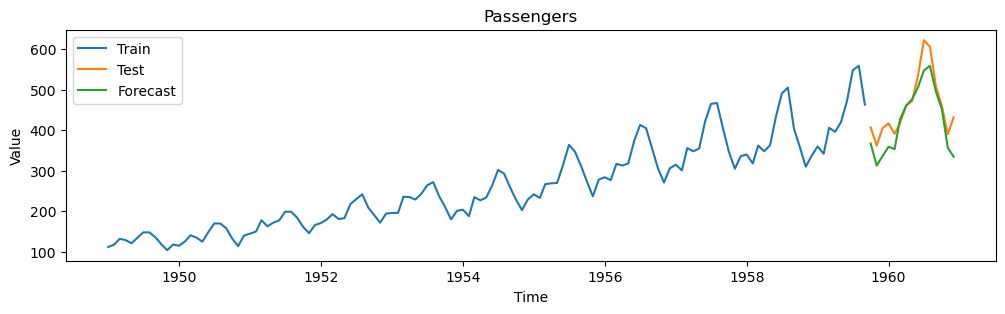

In [10]:
plt.figure(figsize=(12,3))
plt.plot(train[date_variable], train[ts_variable], label = f'Train')
plt.plot(test[date_variable], test[ts_variable], label = f'Test')
plt.plot(test[date_variable], predict_data["target"], label = f'Forecast')
plt.plot()
plt.title(f"{ts_variable}")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show() 

### Different Models Forecast

SOON